In [13]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [14]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [15]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=32, out_features=24)
        self.out = nn.Linear(in_features=32, out_features=2)
    #end
    
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t
    #end
# end

In [16]:
Experience = namedtuple('Experience', ('state', 'action', 'next_tuple', 'reward'))

In [17]:
e = Experience(2,3,1,4)

In [18]:
print(e)

Experience(state=2, action=3, next_tuple=1, reward=4)


In [19]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    #end
    
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        #end
        self.push_count += 1
    #end
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    #end
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size
    #end
#end

In [20]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    #end
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)
    #end
#end

In [21]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    #end
    
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            return random.randrange(self.num_actions) #explore
        else:
            with torch.no_grad: # Just for inference, not grading
                return policy_net(state).argmax(dim=1).to(device) #exploit
            #end
        #end
    #end
#end

In [22]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    #end
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
    #end
    
    def close(self):
        self.env.close()
    #end
    
    def render(self, mode='human'):
        return self.env.render(mode)
    #end
    
    def num_actions_available(self):
        return self.env.action_space.n
    #end
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    #end
    
    def just_starting(self):
        return self.current_screen is None
    #end
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        #end
    #end
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    #end
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    #end
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1)) #PyTorch
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    #end
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    #end
    
    def transform_screen_data(self, screen):
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # Add a batch dimension
    #end
#end

In [23]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)
#end

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    #end
#end

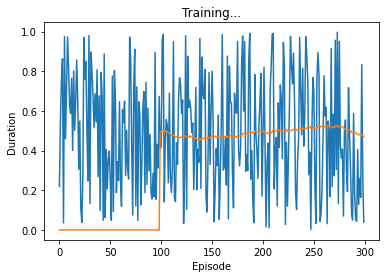

In [24]:
plot(np.random.rand(300), 100)

In [25]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1,t2,t3,t4)
#end

In [26]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    #end
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values
    #end
#end

In [27]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #end
        
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
        #end
        
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    #end
    
em.close()
#end

AttributeError: 'int' object has no attribute 'item'